In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)  # Show all columns when displaying a DataFrame
pd.set_option('display.max_rows', None)  # Show all rows when displaying a Data
warnings.filterwarnings('ignore')

In [ ]:
# Run .py file to generate processed CSV
exec(open('/Users/jiajue/Documents/McGill/Fall Term/Independent study/player_profile.py').read())

# Open processed & original player profile csv
df = pd.read_csv('/Users/jiajue/Documents/McGill/Fall Term/Independent study/player_profile_processed.csv')
org_df = pd.read_csv('/Users/jiajue/Documents/McGill/Fall Term/Independent study/player_profile.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 87 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   player_id                           5000 non-null   int64  
 1   last_play                           5000 non-null   object 
 2   covid_flag                          5000 non-null   int64  
 3   active_days                         5000 non-null   float64
 4   engage_duration                     5000 non-null   int64  
 5   activity_ratio                      5000 non-null   float64
 6   level_9_puzzles                     5000 non-null   int64  
 7   total_puzzles                       5000 non-null   float64
 8   level9_category                     5000 non-null   object 
 9   prop_level_1_excess                 5000 non-null   float64
 10  binary_level_1_excess               5000 non-null   int64  
 11  prop_level_2_excess                 5000 no

### Cox Regression Model

**Time component:** Number of puzzles completed in level 9

**Event component:** Whether the player has churned

#### Both LASSO & Elastic Net were attempted

Key terms:
- C-index compares pairs of players and the value is the proportion where the earlier churner had the higher predicted risk. Used as the basis of comparison across models on which is superior.

In [4]:
# Select predictors
predictors = [col for col in df.columns if col not in ['player_id', 'event', 'level9_category', 'level_9_puzzles', 'days_since_last_play', 'last_play']]

# Prepare data for Cox regression
survival_data = df[['level_9_puzzles', 'event'] + predictors]

### **Penalised Cox model with efficiency penalty based on number of features** 

In [5]:
def penalised_cox(data, predictors, method='lasso', 
                 alphas = np.logspace(-6, 1, 12),
                 l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9],
                 validation_method='train_test',
                 test_size=0.2, n_folds=5, n_runs=5,
                 final_model_strategy='retrain',
                 return_consensus=True,
                 # Efficiency parameters to penalise model complexity
                 feature_efficiency_weight=0.0,  # How much to penalise a model for having too many features
                 max_features_penalty=50):       # upper limit on feature count for penalty
    
    # Set L1 ratios based on method 
    if method == 'lasso':
        l1_ratios = [1.0]
    elif method == 'ridge':
        l1_ratios = [0.0]

    all_models = []
    best_hyperparams = None
    best_validation_score = 0  # instead of best_validation_cindex
    best_individual_model = None 
    
    # Efficiency score calculation function
    def calculate_efficiency_score(cindex, num_features):
        feature_penalty = min(num_features / max_features_penalty, 1.0) # Cap penalty at 1
        return cindex - (feature_efficiency_weight * feature_penalty)
    
    # Helper function
    def fit_and_evaluate(train_data, test_data, alpha, l1_ratio, run_idx=None, fold_idx=None):
        try:
            pcph = CoxPHFitter(penalizer=alpha, l1_ratio=l1_ratio)
            pcph.fit(train_data, 
                    duration_col='level_9_puzzles',
                    event_col='event',
                    formula=' + '.join(predictors),
                    show_progress=False)
            
            test_scores = -pcph.predict_partial_hazard(test_data)
            test_cindex = concordance_index(test_data['level_9_puzzles'],
                                          test_scores, 
                                          test_data['event'])

            num_features = (np.abs(pcph.params_) > 1e-6).sum()
            
            # Calculate efficiency score
            efficiency_score = calculate_efficiency_score(test_cindex, num_features)
            
            model_info = {
                'model': pcph,
                'alpha': alpha,
                'l1_ratio': l1_ratio,
                'cindex': test_cindex,
                'num_features': num_features,
                'efficiency_score': efficiency_score,
                'method': method,
                'run': run_idx,
                'fold': fold_idx
            }
            
            return model_info, test_cindex, efficiency_score 
            
        except Exception as e:
            print(f"  Failed: {str(e)[:80]}...")
            return None, 0, 0
    
    # Train/Test Validation
    if validation_method == 'train_test':
        print(f"=== {method.upper()} - Train/Test Validation ({n_runs} runs) ===")
        print(f"Using feature efficiency weight: {feature_efficiency_weight}")
        for run in range(n_runs):
            print(f"\n--- Run {run+1}/{n_runs} ---")
            train_data, test_data = train_test_split(data, test_size=test_size, shuffle=True,
                                                   random_state=run)
            
            for alpha in alphas:
                for l1_ratio in l1_ratios:
                    # Get both cindex and efficiency_score
                    model_info, cindex, efficiency_score = fit_and_evaluate(train_data, test_data, alpha, l1_ratio, run_idx=run)
                    if model_info:
                        all_models.append(model_info)
                        # Show both scores
                        print(f"  α: {alpha:6.3f}, L1: {l1_ratio:.1f}, C-index: {cindex:.4f}, Features: {model_info['num_features']:2d}, Eff-Score: {efficiency_score:.4f}")
                        
                        # Track best model using efficiency score
                        if efficiency_score > best_validation_score:
                            best_validation_score = efficiency_score
                            best_individual_model = model_info['model']
                            best_hyperparams = {
                                'alpha': alpha, 
                                'l1_ratio': l1_ratio, 
                                'run': run,
                                'raw_cindex': cindex,  # store original cindex
                                'num_features': model_info['num_features'] 
                            }
    
    # Cross-Validation 
    elif validation_method == 'cv':
        print(f"=== {method.upper()} - {n_folds}-Fold Cross Validation ===")
        print(f"Using feature efficiency weight: {feature_efficiency_weight}")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        hyperparam_performance = []
        
        for alpha in alphas:
            for l1_ratio in l1_ratios:
                fold_scores = []  # tracking efficiency scores
                fold_cindexes = []  # track raw cindex for display
                
                for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
                    train_data = data.iloc[train_idx]
                    test_data = data.iloc[test_idx]

                    # Get both scores
                    model_info, cindex, efficiency_score = fit_and_evaluate(train_data, test_data, alpha, l1_ratio, fold_idx=fold)
                    if model_info:
                        all_models.append(model_info)
                        fold_scores.append(efficiency_score)  # Use efficiency score
                        fold_cindexes.append(cindex)  # Keep for display
                
                if fold_scores:
                    mean_score = np.mean(fold_scores)  # mean of efficiency scores
                    std_score = np.std(fold_scores)
                    mean_cindex = np.mean(fold_cindexes)  # For display
                    # show both scores
                    print(f"α: {alpha:6.3f}, L1: {l1_ratio:.1f}, CV C-index: {mean_cindex:.4f}, CV Eff-Score: {mean_score:.4f} ± {std_score:.4f}")
                    
                    hyperparam_performance.append({
                        'alpha': alpha,
                        'l1_ratio': l1_ratio,
                        'mean_score': mean_score, # mean of efficiency scores
                        'std_score': std_score,
                        'fold_scores': fold_scores
                    })
                    
                    # use efficiency score for selection
                    if mean_score > best_validation_score:
                        best_validation_score = mean_score
                        best_hyperparams = {
                            'alpha': alpha, 
                            'l1_ratio': l1_ratio,
                            'raw_cindex': mean_cindex 
                        }
        
        # No best individual model for CV
        best_individual_model = None

    # Final model strategy
    final_model = None
    if validation_method == 'train_test':
        if final_model_strategy == 'retrain' and best_hyperparams:
            print(f"\n--- Retraining on Full Data ---")
            final_model = CoxPHFitter(penalizer=best_hyperparams['alpha'], 
                                    l1_ratio=best_hyperparams['l1_ratio'])
            final_model.fit(data, 
                        duration_col='level_9_puzzles',
                        event_col='event',
                        formula=' + '.join(predictors),
                        show_progress=False)
            final_cindex = final_model.concordance_index_
            print(f"Final model C-index (full data): {final_cindex:.4f}")
        
        elif final_model_strategy == 'use_best' and best_individual_model:
            print(f"\n--- Using Best Validation Model ---")
            final_model = best_individual_model
            print(f"Final model C-index (validation): {best_hyperparams.get('raw_cindex', best_validation_score):.4f}")  # MODIFIED
    
    elif validation_method == 'cv':
        if best_hyperparams:
            print(f"\n--- Retraining on Full Data ---")
            final_model = CoxPHFitter(penalizer=best_hyperparams['alpha'], 
                                    l1_ratio=best_hyperparams['l1_ratio'])
            final_model.fit(data, 
                        duration_col='level_9_puzzles',
                        event_col='event',
                        formula=' + '.join(predictors),
                        show_progress=False)
            final_cindex = final_model.concordance_index_
            print(f"Final model C-index (full data): {final_cindex:.4f}")

    # Feature consensus
    consensus_results = None
    if return_consensus and all_models:
        consensus_results = get_robust_consensus(all_models)
    
    return {
        'final_model': final_model, 
        'best_hyperparams': best_hyperparams,
        'best_validation_score': best_validation_score,  # CHANGED: renamed
        'all_models': all_models,
        'consensus': consensus_results,
        'method': method,
        'validation_method': validation_method,
        'final_model_strategy': final_model_strategy
    }

def get_robust_consensus(all_models, coef_threshold=0.01, 
                        performance_weighted=False):
    """
    Feature extraction with performance weighting flexibility
    """
    
    print(f"Analyzing consensus across {len(all_models)} total models")
    
    feature_stats = {}
    total_models_used = len(all_models)

    for model_info in all_models:
        model = model_info['model']
        # Use model performance as weight
        model_weight = model_info.get('efficiency_score', model_info['cindex']) if performance_weighted else 1.0
        
        for feature, coef in model.params_.items():
            if abs(coef) > coef_threshold:
                if feature not in feature_stats:
                    feature_stats[feature] = {
                        'weighted_coefficients': [],
                        'raw_coefficients': [],
                        'hazard_ratios': [],
                        'selection_count': 0,
                        'weighted_selection': 0,
                        'positive_count': 0,  
                        'negative_count': 0,
                        'model_weights': []
                    }
                
                # Store both weighted and raw values
                feature_stats[feature]['weighted_coefficients'].append(coef * model_weight)
                feature_stats[feature]['raw_coefficients'].append(coef)
                feature_stats[feature]['hazard_ratios'].append(np.exp(coef))
                feature_stats[feature]['model_weights'].append(model_weight)
                feature_stats[feature]['selection_count'] += 1
                feature_stats[feature]['weighted_selection'] += model_weight
                
                # Count direction
                if coef > 0:
                    feature_stats[feature]['positive_count'] += 1
                else:
                    feature_stats[feature]['negative_count'] += 1
    
    # Calculate consensus metrics
    consensus_results = []
    for feature, stats in feature_stats.items():
        total_selections = stats['selection_count']
        
        # Weighted selection rate (models are weighted by performance)
        weighted_selection_rate = stats['weighted_selection'] / sum(stats['model_weights'])
        
        # Raw selection rate
        raw_selection_rate = stats['selection_count'] / total_models_used
        
        # Direction metrics
        positive_fraction = stats['positive_count'] / total_selections
        negative_fraction = stats['negative_count'] / total_selections
        direction_agreement = max(positive_fraction, negative_fraction)
        
        # Determine majority direction
        if stats['positive_count'] > stats['negative_count']:
            majority_direction = 'positive'
            majority_fraction = positive_fraction
        elif stats['negative_count'] > stats['positive_count']:
            majority_direction = 'negative' 
            majority_fraction = negative_fraction
        else:
            majority_direction = 'mixed'
            majority_fraction = 0.5
        
        # Calculate weighted averages
        weighted_avg_coef = np.average(stats['raw_coefficients'], weights=stats['model_weights'])
        weighted_avg_hr = np.exp(weighted_avg_coef)
        
        consensus_results.append({
            'feature': feature,
            'selection_rate': weighted_selection_rate if performance_weighted else raw_selection_rate,
            'raw_selection_rate': raw_selection_rate,
            'direction_agreement': direction_agreement,
            'majority_direction': majority_direction,
            'majority_fraction': majority_fraction,
            'avg_coefficient': weighted_avg_coef,
            'avg_hazard_ratio': weighted_avg_hr,
            'times_selected': stats['selection_count'],
            'total_models_considered': total_models_used,
            'performance_weighted': performance_weighted
        })
    
    # Sort by selection rate
    consensus_results.sort(key=lambda x: x['selection_rate'], reverse=True)
    
    return consensus_results

def display_consensus_table(consensus_list, min_selection_rate=0.5, top_k=20, 
                          show_confidence=True, show_direction_agreement=True):
    """
    Formatted display with metrics for reference
    """
    if not consensus_list:
        print("No consensus results to display")
        return
    
    # Filter by selection rate
    filtered = [f for f in consensus_list if f['selection_rate'] >= min_selection_rate]
    
    # Take top K
    if top_k:
        filtered = filtered[:top_k]
    
    print("\n" + "="*100)
    print(f"FEATURE CONSENSUS RANKING - {filtered[0]['total_models_considered']} MODELS")
    print("="*100)
    
    if show_confidence:
        headers = f"{'Rank':4} {'Feature':30} {'Selected':12} {'Dir':4} {'Agree':6} {'Avg HR':8} {'Confidence':10} {'Models'}"
    else:
        headers = f"{'Rank':4} {'Feature':30} {'Selected':12} {'Dir':4} {'Avg HR':8} {'Models'}"
    
    print(headers)
    print("-"*100)
    
    for i, feature_data in enumerate(filtered, 1):
        feature = feature_data['feature']
        selected = f"{feature_data['selection_rate']:.0%}"
        direction = feature_data['majority_direction'][:1].upper()  # P or N
        hr = f"{feature_data['avg_hazard_ratio']:.2f}"
        models = f"{feature_data['times_selected']}/{feature_data['total_models_considered']}"
        
        row = f"{i:4} {feature:30} {selected:12} {direction:4} {hr:8} {models:8}"
        
        if show_confidence:
            # Enhanced confidence calculation
            selection_strength = feature_data['selection_rate']
            direction_strength = feature_data['direction_agreement']
            
            if selection_strength >= 0.8 and direction_strength >= 0.9:
                confidence = "HIGH"
            elif selection_strength >= 0.6 and direction_strength >= 0.8:
                confidence = "MED-HIGH"
            elif selection_strength >= 0.5:
                confidence = "MEDIUM"
            else:
                confidence = "LOW"
            
            if show_direction_agreement:
                agree = f"{feature_data['direction_agreement']:.0%}"
                row = f"{i:4} {feature:30} {selected:12} {direction:4} {agree:6} {hr:8} {confidence:10} {models:8}"
            else:
                row = f"{i:4} {feature:30} {selected:12} {direction:4} {hr:8} {confidence:10} {models:8}"
        
        print(row)
    
    print("="*100)
    print(f"Showing {len(filtered)} features (selection rate ≥ {min_selection_rate:.0%})")
    if consensus_list[0]['performance_weighted']:
        print("✓ Performance-weighted consensus")
    else:
        print("✓ Unweighted consensus (all models equal)")

#### Attempt 1: LASSO with feature weight = 0

In [212]:
# Call on lasso model
lasso_results = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='lasso',
    feature_efficiency_weight=0.0,  # No feature efficiency penalty
    validation_method='train_test',
    n_runs=5
)

=== LASSO - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.0

--- Run 1/5 ---
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 1.0, C-index: 0.6096, Features: 81, Eff-Score: 0.6096
  α:  0.000, L1: 1.0, C-index: 0.6099, Features: 81, Eff-Score: 0.6099
  α:  0.000, L1: 1.0, C-index: 0.6112, Features: 81, Eff-Score: 0.6112
  α:  0.002, L1: 1.0, C-index: 0.6123, Features: 79, Eff-Score: 0.6123
  α:  0.007, L1: 1.0, C-index: 0.6134, Features: 50, Eff-Score: 0.6134
  α:  0.028, L1: 1.0, C-index: 0.6115, Features: 12, Eff-Score: 0.6115
  α:  0.123, L1: 1.0, C-index: 0.6065, Features:  3, Eff-Score: 0.6065
  α:  0.534, L1: 1.0, C-index: 0.6045, Features:  1, Eff-Score: 0.6045
  α:  2.310, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6044
  α: 10.000, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6044

--- Run 2/5 ---
  α:  0.000, L1: 1.0, C-index:

In [213]:
# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {lasso_results['best_hyperparams']}")
print(f"Best validation score: {lasso_results['best_validation_score']:.4f}")
if lasso_results['final_model']:
    print(f"Final model C-index: {lasso_results['final_model'].concordance_index_:.4f}")

kmeans_variables = []

if lasso_results['consensus']:
    kmeans_variables = [feature['feature'] for feature in lasso_results['consensus'][:20]]
    display_consensus_table(
        lasso_results['consensus']
    )
else:
    print("No consensus results available")


FINAL MODEL SUMMARY
Best hyperparameters: {'alpha': np.float64(0.006579332246575682), 'l1_ratio': 1.0, 'run': 0, 'raw_cindex': np.float64(0.6134291277189953), 'num_features': np.int64(50)}
Best validation score: 0.6134
Final model C-index: 0.6053

FEATURE CONSENSUS RANKING - 60 MODELS
Rank Feature                        Selected     Dir  Agree  Avg HR   Confidence Models
----------------------------------------------------------------------------------------------------
   1 active_days                    75%          N    100%   0.81     MED-HIGH   45/60   
   2 puzzles_relative_excess_corr   75%          N    100%   0.66     MED-HIGH   45/60   
   3 binary_level_1_excess          67%          N    100%   0.74     MED-HIGH   40/60   
   4 puzzles_excess_corr            65%          N    100%   0.46     MED-HIGH   39/60   
   5 avg_session_intensity          65%          N    56%    1.10     MEDIUM     39/60   
   6 binary_level_7_excess          63%          N    100%   0.58     MED-

#### Attempt 2: Lasso with weight = 0.01

In [201]:
# Call on lasso model
lasso_results = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='lasso',
    feature_efficiency_weight=0.01,  # Slight penalty for features
    validation_method='train_test',
    n_runs=5
)

=== LASSO - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.01

--- Run 1/5 ---
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.5995
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.5995
  α:  0.000, L1: 1.0, C-index: 0.6096, Features: 81, Eff-Score: 0.5996
  α:  0.000, L1: 1.0, C-index: 0.6099, Features: 81, Eff-Score: 0.5999
  α:  0.000, L1: 1.0, C-index: 0.6112, Features: 81, Eff-Score: 0.6012
  α:  0.002, L1: 1.0, C-index: 0.6123, Features: 79, Eff-Score: 0.6023
  α:  0.007, L1: 1.0, C-index: 0.6134, Features: 50, Eff-Score: 0.6034
  α:  0.028, L1: 1.0, C-index: 0.6115, Features: 12, Eff-Score: 0.6091
  α:  0.123, L1: 1.0, C-index: 0.6065, Features:  3, Eff-Score: 0.6059
  α:  0.534, L1: 1.0, C-index: 0.6045, Features:  1, Eff-Score: 0.6043
  α:  2.310, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6042
  α: 10.000, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6042

--- Run 2/5 ---
  α:  0.000, L1: 1.0, C-index

In [204]:
# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {lasso_results['best_hyperparams']}")
print(f"Best validation score: {lasso_results['best_validation_score']:.4f}")
if lasso_results['final_model']:
    print(f"Final model C-index: {lasso_results['final_model'].concordance_index_:.4f}")

for key, item in [('Lasso', lasso_results['all_models'])]:
    print(f"\n=== Robust Consensus for {key} ===")
    consensus = get_robust_consensus(item)
    kmeans_variables = [feature['feature'] for feature in consensus[:20]]
    display_consensus_table(consensus)



FINAL MODEL SUMMARY
Best hyperparameters: {'alpha': np.float64(0.02848035868435799), 'l1_ratio': 1.0, 'run': 0, 'raw_cindex': np.float64(0.6115217563674487), 'num_features': np.int64(12)}
Best validation score: 0.6091
Final model C-index: 0.5986

=== Robust Consensus for Lasso ===
Analyzing consensus across 60 total models

FEATURE CONSENSUS RANKING - 60 MODELS
Rank Feature                        Selected     Dir  Agree  Avg HR   Confidence Models
----------------------------------------------------------------------------------------------------
   1 active_days                    75%          N    100%   0.81     MED-HIGH   45/60   
   2 puzzles_relative_excess_corr   75%          N    100%   0.66     MED-HIGH   45/60   
   3 binary_level_1_excess          67%          N    100%   0.74     MED-HIGH   40/60   
   4 puzzles_excess_corr            65%          N    100%   0.46     MED-HIGH   39/60   
   5 avg_session_intensity          65%          N    56%    1.10     MEDIUM     39/60

#### Attempt 3: Lasso with weight = 0.02

In [205]:
# Call on lasso model
lasso_results = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='lasso',
    feature_efficiency_weight=0.02,  # Increase penalty to compare difference
    validation_method='train_test',
    n_runs=5
)

# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {lasso_results['best_hyperparams']}")
print(f"Best validation score: {lasso_results['best_validation_score']:.4f}")
if lasso_results['final_model']:
    print(f"Final model C-index: {lasso_results['final_model'].concordance_index_:.4f}")

for key, item in [('Lasso', lasso_results['all_models'])]:
    print(f"\n=== Robust Consensus for {key} ===")
    consensus = get_robust_consensus(item)
    kmeans_variables = [feature['feature'] for feature in consensus[:20]]
    display_consensus_table(consensus)


=== LASSO - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.02

--- Run 1/5 ---
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 1.0, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 1.0, C-index: 0.6096, Features: 81, Eff-Score: 0.5896
  α:  0.000, L1: 1.0, C-index: 0.6099, Features: 81, Eff-Score: 0.5899
  α:  0.000, L1: 1.0, C-index: 0.6112, Features: 81, Eff-Score: 0.5912
  α:  0.002, L1: 1.0, C-index: 0.6123, Features: 79, Eff-Score: 0.5923
  α:  0.007, L1: 1.0, C-index: 0.6134, Features: 50, Eff-Score: 0.5934
  α:  0.028, L1: 1.0, C-index: 0.6115, Features: 12, Eff-Score: 0.6067
  α:  0.123, L1: 1.0, C-index: 0.6065, Features:  3, Eff-Score: 0.6053
  α:  0.534, L1: 1.0, C-index: 0.6045, Features:  1, Eff-Score: 0.6041
  α:  2.310, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6040
  α: 10.000, L1: 1.0, C-index: 0.6044, Features:  1, Eff-Score: 0.6040

--- Run 2/5 ---
  α:  0.000, L1: 1.0, C-index

The same features are obtained regardless of the penalty imposed, making the final feature set more robust.

#### Attempt 1 with Elastic Net with weight = 0

In [6]:
# Call on elastic net model
elastic_net_results = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='elastic_net',
    feature_efficiency_weight=0.0,  
    validation_method='train_test',
    n_runs=5
)

=== ELASTIC_NET - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.0

--- Run 1/5 ---
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.6095
  α:  0.000, L1: 0.3, C-index: 0.6096, Features: 81, Eff-Score: 0.6096
  α:  0.000, L1: 0.5, C-index: 0.6096, Fe

In [7]:
# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {elastic_net_results['best_hyperparams']}")
print(f"Best validation score: {elastic_net_results['best_validation_score']:.4f}")
if elastic_net_results['final_model']:
    print(f"Final model C-index: {elastic_net_results['final_model'].concordance_index_:.4f}")

kmeans_variables = []

if elastic_net_results['consensus']:
    kmeans_variables = [feature['feature'] for feature in elastic_net_results['consensus'][:20]]
    display_consensus_table(
        elastic_net_results['consensus']
    )
else:
    print("No consensus results available")


FINAL MODEL SUMMARY
Best hyperparameters: {'alpha': np.float64(0.12328467394420659), 'l1_ratio': 0.1, 'run': 0, 'raw_cindex': np.float64(0.6144224585267869), 'num_features': np.int64(32)}
Best validation score: 0.6144
Final model C-index: 0.6022

FEATURE CONSENSUS RANKING - 300 MODELS
Rank Feature                        Selected     Dir  Agree  Avg HR   Confidence Models
----------------------------------------------------------------------------------------------------
   1 puzzles_relative_excess_corr   78%          N    100%   0.67     MED-HIGH   235/300 
   2 active_days                    77%          N    100%   0.80     MED-HIGH   231/300 
   3 avg_session_intensity          74%          N    59%    1.07     MEDIUM     222/300 
   4 puzzles_excess_corr            72%          N    100%   0.46     MED-HIGH   215/300 
   5 binary_level_7_excess          70%          N    100%   0.58     MED-HIGH   211/300 
   6 avg_puzzles_per_session        70%          P    100%   1.38     MED-

#### Attempt 2 with Elastic Net with weight = 0.02

In [236]:
# Call on elastic net model
elastic_net_results2 = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='elastic_net',
    feature_efficiency_weight=0.02,  
    validation_method='train_test',
    n_runs=5
)

# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {elastic_net_results2['best_hyperparams']}")
print(f"Best validation score: {elastic_net_results2['best_validation_score']:.4f}")
if elastic_net_results2['final_model']:
    print(f"Final model C-index: {elastic_net_results2['final_model'].concordance_index_:.4f}")

kmeans_variables2 = []

if elastic_net_results2['consensus']:
    kmeans_variables2 = [feature['feature'] for feature in elastic_net_results2['consensus'][:20]]
    display_consensus_table(
        elastic_net_results2['consensus']
    )
else:
    print("No consensus results available")

=== ELASTIC_NET - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.02

--- Run 1/5 ---
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5895
  α:  0.000, L1: 0.3, C-index: 0.6096, Features: 81, Eff-Score: 0.5896
  α:  0.000, L1: 0.5, C-index: 0.6096, F

#### Attempt 3 with Elastic Net with weight = 0.1

In [239]:
# Call on elastic net model
elastic_net_results3 = penalised_cox(
    data=survival_data,
    predictors=predictors,
    method='elastic_net',
    feature_efficiency_weight=0.1,  
    validation_method='train_test',
    n_runs=5
)

# Then display the results
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best hyperparameters: {elastic_net_results3['best_hyperparams']}")
print(f"Best validation score: {elastic_net_results3['best_validation_score']:.4f}")
if elastic_net_results3['final_model']:
    print(f"Final model C-index: {elastic_net_results3['final_model'].concordance_index_:.4f}")

kmeans_variables3 = []

if elastic_net_results3['consensus']:
    kmeans_variables3 = [feature['feature'] for feature in elastic_net_results3['consensus'][:20]]
    display_consensus_table(
        elastic_net_results3['consensus']
    )
else:
    print("No consensus results available")

=== ELASTIC_NET - Train/Test Validation (5 runs) ===
Using feature efficiency weight: 0.1

--- Run 1/5 ---
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.3, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.5, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.7, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.9, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.1, C-index: 0.6095, Features: 81, Eff-Score: 0.5095
  α:  0.000, L1: 0.3, C-index: 0.6096, Features: 81, Eff-Score: 0.5096
  α:  0.000, L1: 0.5, C-index: 0.6096, Fe

Same observation in the features obtained as with the lasso model trials across different weights applied to the elastic net model.

## **Clustering**

In [13]:
def evaluate_clustering(df, feature_cols, k_range=(2, 16), random_state=42):
    """
    Optimal clustering evaluation
    """
    # Setup plotting
    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 11

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Storage for metrics
    withinss = []
    silhouette_scores = []
    calinski_scores = [] 
    
    k_values = list(range(k_range[0], k_range[1]))
    
    # Log then standardise level 9 puzzle count before clustering
    log_scale_pipeline = Pipeline([
                        ('log', FunctionTransformer(np.log1p, validate=True)), 
                        ('scale', StandardScaler())
                    ])
    
    preprocessor = ColumnTransformer(
                        transformers=[
                            ('log_then_scale', log_scale_pipeline, ['level_9_puzzles'])
                        ],
                        remainder='passthrough'  # keeps the other columns unchanged
                    )

    # Transform data
    X_transformed = preprocessor.fit_transform(df[feature_cols])

    print("Clustering Evaluation Results:")
    print("k | Inertia | Silhouette | Calinski-Harabasz")
    print("=" * 50)
    
    for k in k_values:
        # Fit KMeans with multiple initialisations for stability
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_transformed)
        # Get inertia
        withinss.append(kmeans.inertia_)

        # Silhouette score
        silhouette_avg = silhouette_score(X_transformed, labels)
        silhouette_scores.append(silhouette_avg)
            
        # Calinski-Harabasz score
        calinski = calinski_harabasz_score(X_transformed, labels)
        calinski_scores.append(calinski)
            
        print(f"{k} | {kmeans.inertia_:8.0f} | {silhouette_avg:8.4f} | {calinski:18.0f}")

    # Elbow Plot with 2 methods
    ax1.plot(k_values, withinss, 'bo-', alpha=0.7, linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Within-cluster Sum of Squares')
    ax1.set_title('A. Elbow Method', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Get both elbow suggestions
    elbow_curvature = find_elbow_curvature(withinss, k_values)
    elbow_distance = find_elbow_distance(withinss, k_values)
    
    # Plot both suggestions
    ax1.axvline(x=elbow_curvature, color='red', linestyle='--', alpha=0.7, 
                label=f'Curvature method: k={elbow_curvature}')
    ax1.axvline(x=elbow_distance, color='orange', linestyle='--', alpha=0.7, 
                label=f'Distance method: k={elbow_distance}')
    ax1.legend()
    
    # Silhouette Scores Plot
    ax2.plot(k_values, silhouette_scores, 'ro-', alpha=0.7, linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Average Silhouette Score')
    ax2.set_title('B. Silhouette Analysis', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Mark best silhouette score
    silhouette_k = k_values[np.argmax(silhouette_scores)]
    ax2.axvline(x=silhouette_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: k={silhouette_k}')
    ax2.legend()
    
    # Calinski-Harabasz Plot
    ax3.plot(k_values, calinski_scores, 'go-', alpha=0.7, linewidth=2, markersize=8)
    ax3.set_xlabel('Number of Clusters (k)')
    ax3.set_ylabel('Calinski-Harabasz Score')
    ax3.set_title('C. Calinski-Harabasz', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Mark best Calinski score
    calinski_k = k_values[np.argmax(calinski_scores)]
    ax3.axvline(x=calinski_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: k={calinski_k}')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 50)
    print("SUGGESTED K VALUES (Test these):")
    print(f"Elbow (Curvature): k = {elbow_curvature}")
    #print(f"Elbow (Distance):  k = {elbow_distance}")
    #print(f"Silhouette:        k = {silhouette_k}")
    print(f"Calinski-Harabasz: k = {calinski_k}")
    
    return {
        'withinss': withinss,
        'silhouette_scores': silhouette_scores, 
        'calinski_scores': calinski_scores,
        'elbow_curvature_k': elbow_curvature,
        'elbow_distance_k': elbow_distance,
        #'silhouette_k': silhouette_k,
        'calinski_k': calinski_k
    }


def find_elbow_curvature(withinss, k_values):
    """
    Elbow detection using maximum curvature method
    """
    if len(withinss) >= 3:
        first_diff = np.diff(withinss)
        second_diff = np.diff(first_diff)
        # Find point where the decrease slows down most
        curvature_idx = np.argmax(np.abs(second_diff)) 
        return k_values[curvature_idx + 1]  
    else:
        return k_values[0]


def find_elbow_distance(withinss, k_values):
    """
    Elbow detection using distance from line method
    """
    if len(withinss) < 3:
        return k_values[0]
    
    # Draw line from first to last point
    first_point = np.array([k_values[0], withinss[0]])
    last_point = np.array([k_values[-1], withinss[-1]])
    
    max_distance = 0
    elbow_k = k_values[0]
    
    for k, wss in zip(k_values, withinss):
        point = np.array([k, wss])
        distance = np.abs(np.cross(last_point - first_point, first_point - point)) / \
                   np.linalg.norm(last_point - first_point)
        
        if distance > max_distance:
            max_distance = distance
            elbow_k = k
    
    return elbow_k

Clustering Evaluation Results:
k | Inertia | Silhouette | Calinski-Harabasz
2 |    13841 |   0.3537 |               2042
3 |    10531 |   0.2998 |               2127
4 |     8930 |   0.2505 |               1970
5 |     8074 |   0.2365 |               1766
6 |     7387 |   0.2282 |               1637
7 |     6907 |   0.1975 |               1517
8 |     6500 |   0.1964 |               1426
9 |     6195 |   0.1951 |               1339
10 |     5878 |   0.1961 |               1284
11 |     5623 |   0.1828 |               1231
12 |     5424 |   0.1778 |               1176
13 |     5282 |   0.1845 |               1118
14 |     5107 |   0.1729 |               1081
15 |     4950 |   0.1770 |               1046


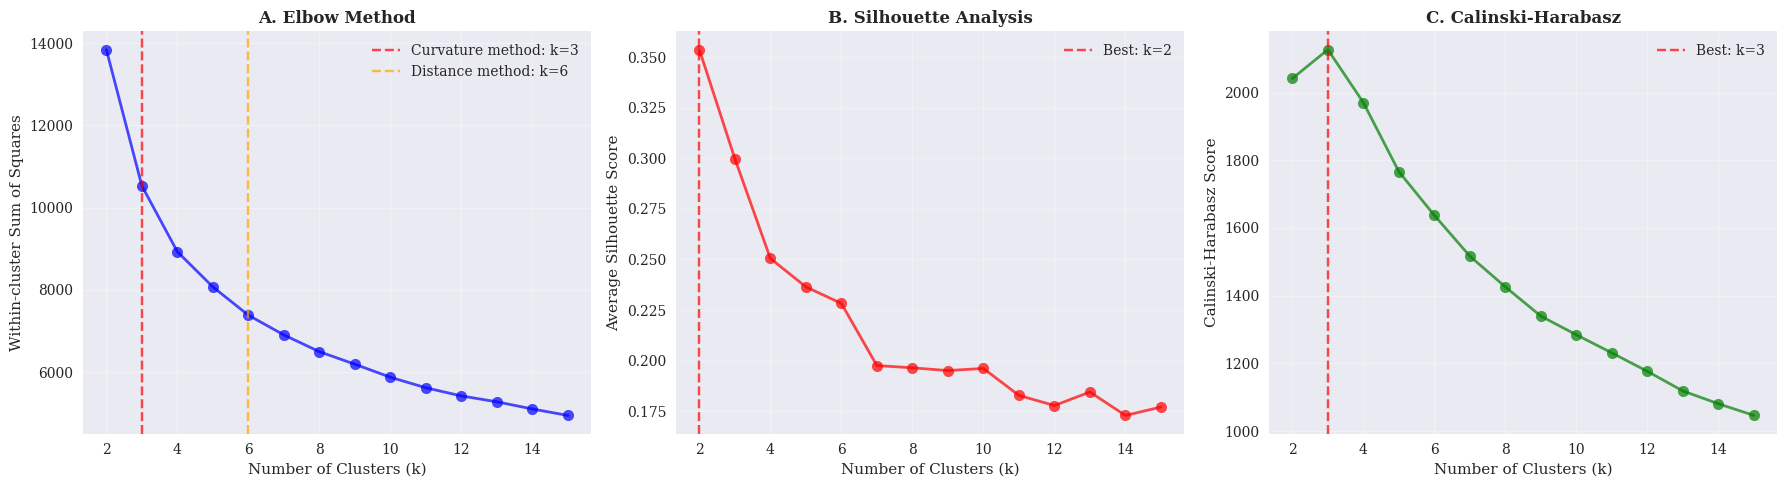


SUGGESTED K VALUES (Test these):
Elbow (Curvature): k = 3
Calinski-Harabasz: k = 3


In [14]:
# Exclude temporal variables & std vars from clustering. To introduce the level 9 puzzle count as well
revised_kmeans_var = [var for var in kmeans_variables if var not in
                      ['std_prop_clicks_after_par', 'std_time_per_click_after_par', 'month_5', 'month_7', 'month_9', 'month_2']] \
                        + ['level_9_puzzles']

results = evaluate_clustering(df, revised_kmeans_var)

In [10]:
def analyse_clusters(transformed_df, original_df, features, k, target_col='level_9_puzzles'):
    """
    Cluster analysis using transformed data for clustering but original data for interpretation
    
    """

    # Set up plotting style
    plt.rcParams['font.family'] = 'serif'  # Use serif font for academic papers
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.linewidth'] = 0.8  # Thinner axes lines

    # Perform final transformation on level 9 puzzle count before clustering
    log_scale_pipeline = Pipeline([
                        ('log', FunctionTransformer(np.log1p, validate=True)), 
                        ('scale', StandardScaler())
                    ])
    
    preprocessor = ColumnTransformer(
                        transformers=[
                            ('log_then_scale', log_scale_pipeline, ['level_9_puzzles'])
                        ],
                        remainder='passthrough'  # keeps the other columns unchanged
                    )

    # Transform data 
    scaled_data = preprocessor.fit_transform(transformed_df[features])
    #scaled_data = transformed_df[features].values
    
    # Fit Kmeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Create analysis dataframe combining original data with cluster labels and event
    analysis_df = original_df.copy()
    analysis_df['cluster'] = cluster_labels
    for col in ['event', 'years_since_2020', 'month_2', 'month_5', 'month_7', 'month_9']:
        analysis_df[col] = transformed_df[col].values  # Add cols from transformed df

    print(f"\n{'='*80}")
    print(f"CLUSTER ANALYSIS FOR k={k}")
    print(f"{'='*80}")
    
    # 1. Cluster sizes
    cluster_sizes = analysis_df['cluster'].value_counts().sort_index()
    print(f"\nCLUSTER SIZES:")
    for cluster_id, size in cluster_sizes.items():
        percentage = size / len(analysis_df) * 100
        print(f"  Cluster {cluster_id}: {size:4d} players ({percentage:5.1f}%)")
    
    # 2. Target variables with original scale
    print(f"\nTARGET VARIABLES (Original Scale):")
    target_summary = analysis_df.groupby('cluster').agg({
        target_col: ['mean', 'median', 'std', 'count', 'min', 'max'],
        'event': ['mean', 'count']
    }).round(3)
    print(target_summary)
    
    # 3. Feature characteristics in original scale
    print(f"\nCLUSTERING FEATURES (Original Scale):")
    feature_summary = analysis_df.groupby('cluster')[features].agg(['mean', 'median', 'std', 'min', 'max']).round(3)
    print(feature_summary)
    
    # 4. Feature importance with original values
    print(f"\nFEATURE RANKING (Most differentiating features in original scale):")
    overall_means = analysis_df[features].mean()
    cluster_means = analysis_df.groupby('cluster')[features].mean()
    
    deviations = {}
    for cluster_id in range(k):
        # Calculate relative differences
        deviation = (cluster_means.loc[cluster_id] - overall_means).abs()
        rel_deviation = deviation / overall_means
        top_features = rel_deviation.nlargest(5)
        deviations[cluster_id] = top_features
        
        print(f"\nCluster {cluster_id} - Most distinctive features:")
        for feature, rel_diff in top_features.items():
            cluster_val = cluster_means.loc[cluster_id][feature]
            overall_val = overall_means[feature]
            abs_diff = cluster_val - overall_val
            direction = "HIGHER" if cluster_val > overall_val else "LOWER"
            
            print(f"  {feature:30}: {direction}")
            print(f"    Cluster value: {cluster_val:.3f}")
            print(f"    Overall mean:  {overall_val:.3f}")
            print(f"    Abs diff:      {abs_diff:.3f}")
            print(f"    Rel diff:      {rel_diff:.1%}")
    
    # 5. Statistical Significance Table
    print(f"\nSTATISTICAL SIGNIFICANCE OF FEATURE DIFFERENCES (ANOVA):")
    
    anova_results = []
    for feature in features:
        groups = [analysis_df[analysis_df['cluster'] == i][feature] for i in range(k)]
        f_stat, p_value = stats.f_oneway(*groups)
        
        anova_results.append({
            'Feature': feature,
            'F-statistic': f_stat,
            'P-value': p_value,
            'Significant': p_value < 0.05
        })
    
    # Create and display ANOVA results table
    anova_df = pd.DataFrame(anova_results)
    
    # Format for better display
    display_df = anova_df.copy()
    display_df['F-statistic'] = display_df['F-statistic'].round(3)
    display_df['P-value'] = display_df['P-value'].round(4)
    display_df['Significance'] = display_df['P-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'NS'
    )
    
    print("\nANOVA Results Table:")
    print("="*70)
    print(f"{'Feature':<30} {'F-statistic':>10} {'P-value':>10} {'Sig.':>6}")
    print("-"*70)
    
    for _, row in display_df.iterrows():
        print(f"{row['Feature']:<30} {row['F-statistic']:>10.3f} {row['P-value']:>10.4f} {row['Significance']:>6}")
    
    print("="*70)
    print("Significance codes: *** p<0.001, ** p<0.01, * p<0.05, NS=Not Significant")
    
    # Additional summary
    significant_features = anova_df[anova_df['Significant']]['Feature'].tolist()
    print(f"\nSummary: {len(significant_features)}/{len(features)} features show significant differences between clusters")
    
    if significant_features:
        print("Significantly differentiating features:")
        for feat in significant_features:
            print(f"  - {feat}")

    def create_qualitative_comparison(analysis_df, features, k):
        """Create a qualitative table describing clusters relative to each other"""
        cluster_means = analysis_df.groupby('cluster')[features].mean()
        
        print(f"\n{'='*90}")
        print(f"QUALITATIVE CLUSTER COMPARISON")
        print(f"{'='*90}")
        
        # For each feature, rank clusters and assign qualitative descriptors
        for feature in features:
            print(f"\n{feature.upper()}:")
            
            # Get sorted clusters for this feature
            ranked_clusters = cluster_means[feature].sort_values(ascending=False)
            
            # Assign qualitative positions
            positions = {}
            for i, (cluster_id, value) in enumerate(ranked_clusters.items()):
                if i == 0:
                    positions[cluster_id] = "HIGHEST"
                elif i == len(ranked_clusters) - 1:
                    positions[cluster_id] = "LOWEST"
                elif i < len(ranked_clusters) // 3:
                    positions[cluster_id] = "ABOVE AVERAGE"
                elif i > 2 * len(ranked_clusters) // 3:
                    positions[cluster_id] = "BELOW AVERAGE"
                else:
                    positions[cluster_id] = "AVERAGE"
            
            # Print results
            for cluster_id in range(k):
                position = positions[cluster_id]
                value = cluster_means.loc[cluster_id, feature]
                print(f"   Cluster {cluster_id}: {position} ({value:.3f})")

    def create_cluster_archetypes(analysis_df, features, k):
        """Create archetype descriptions for each cluster"""
        cluster_means = analysis_df.groupby('cluster')[features].mean()
        
        print(f"\n{'='*80}")
        print(f"CLUSTER ARCHETYPES")
        print(f"{'='*80}")
        
        for cluster_id in range(k):
            cluster_size = len(analysis_df[analysis_df['cluster'] == cluster_id])
            print(f"\nCLUSTER {cluster_id} (n={cluster_size}):")
            
            # Find features where this cluster ranks highest
            standout_features = []
            for feature in features:
                rankings = cluster_means[feature].rank(ascending=False)
                if rankings[cluster_id] == 1:  # Rank 1 means highest
                    standout_features.append(feature)
            
            # Find features where this cluster ranks lowest
            weakest_features = []
            for feature in features:
                rankings = cluster_means[feature].rank(ascending=True)
                if rankings[cluster_id] == 1:  # Rank 1 means lowest
                    weakest_features.append(feature)
            
            # Generate archetype description
            if standout_features:
                print(f"   STRENGTHS: Leads in {', '.join(standout_features)}")
            if weakest_features:
                print(f"   WEAKNESSES: Lags in {', '.join(weakest_features)}")

    def create_relative_positioning(analysis_df, features, k):
        """Show how clusters relate to each other on key dimensions"""
        cluster_means = analysis_df.groupby('cluster')[features].mean()
        
        print(f"\n{'='*70}")
        print(f"RELATIVE POSITIONING MATRIX")
        print(f"{'='*70}")
        
        # Identify the 2-3 most differentiating features
        feature_variability = {}
        for feature in features:
            cv = cluster_means[feature].std() / cluster_means[feature].mean()  # Coefficient of variation
            feature_variability[feature] = cv
        
        # Top 3 most variable features across clusters
        top_features = sorted(feature_variability, key=feature_variability.get, reverse=True)[:3]
        
        print(f"\nKey Differentiating Features: {', '.join(top_features)}")
        print("\nCluster Positioning:")
        
        for cluster_id in range(k):
            positioning = []
            for feature in top_features:
                rank = cluster_means[feature].rank(ascending=False)[cluster_id]
                total_clusters = len(cluster_means)
                
                if rank == 1:
                    pos = "leader"
                elif rank <= total_clusters // 3:
                    pos = "strong"
                elif rank <= 2 * total_clusters // 3:
                    pos = "moderate"
                else:
                    pos = "developing"
                
                positioning.append(f"{feature}: {pos}")
            
            print(f"   Cluster {cluster_id}: {', '.join(positioning)}")

    print(f"\n{'='*80}")
    print(f"QUALITATIVE CLUSTER INTERPRETATION")
    print(f"{'='*80}")
    
    # Qualitative Comparison Table
    create_qualitative_comparison(analysis_df, features, k)
    
    # Cluster Archetypes
    create_cluster_archetypes(analysis_df, features, k)
    
    # Relative Positioning Matrix
    create_relative_positioning(analysis_df, features, k)

    # Visualise cluster characteristics
    print("\nVISUALISING CLUSTER CHARACTERISTICS:")
    
    # Prepare data for plotting
    # Include level 9 puzzle count in the plot
    cluster_means = analysis_df.groupby('cluster')[features].mean()
    
    # Create heatmap of cluster means
    plt.figure(figsize=(15, len(features)//3))
    sns.heatmap(cluster_means, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                center=0,
                cbar_kws={'label': 'Mean Value'})
    plt.title(f'Cluster Means Heatmap (k={k})', fontweight='bold')
    plt.ylabel('Cluster')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

    # Create parallel coordinates plot
    plt.figure(figsize=(16, 6))
    # Standardise the features for better visualisation
    #### Purpose: Understand cluster characteristic & segmentation
    standardised_means = (cluster_means - cluster_means.mean()) / (cluster_means.std())
    
    # Plot each cluster
    for cluster in range(k):
        plt.plot(range(len(features)), 
                standardised_means.loc[cluster], 
                'o-', 
                label=f'Cluster {cluster}',
                alpha=0.7)

    plt.xticks(range(len(features)), features, rotation=45, ha='right')
    plt.ylabel('Standardised Deviation from Overall Mean')
    plt.title(f'Parallel Coordinates Plot of Cluster Means (k={k})', fontweight='bold')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # legend located outside
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    # Calculate correlations and p-values for each cluster
    #### Purpose of correlation: To identify success factors & intervention points within each cluster
    correlation_data = []
    pvalue_data = []
    
    corr_features = [feat for feat in features if feat != target_col]

    for cluster_id in range(k):
        cluster_data = analysis_df[analysis_df['cluster'] == cluster_id]
        cluster_corrs = {}
        cluster_pvals = {}
        
        for feature in corr_features:
            correlation, p_value = stats.pearsonr(cluster_data[feature], cluster_data[target_col])
            cluster_corrs[feature] = correlation
            cluster_pvals[feature] = p_value
        
        cluster_corrs['cluster'] = f'Cluster {cluster_id}'
        cluster_pvals['cluster'] = f'Cluster {cluster_id}'
        correlation_data.append(cluster_corrs)
        pvalue_data.append(cluster_pvals)
    
    # Create dataframes
    corr_df = pd.DataFrame(correlation_data).set_index('cluster')
    pval_df = pd.DataFrame(pvalue_data).set_index('cluster')
    
    # Create annotation matrix with significance stars
    annotation_matrix = corr_df.copy().astype(str)
    for i in range(len(corr_df)):
        for j in range(len(corr_df.columns)):
            corr_val = corr_df.iloc[i, j]
            p_val = pval_df.iloc[i, j]
            
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            
            annotation_matrix.iloc[i, j] = f"{corr_val:.3f}{stars}"
    
    # Plot the heatmap
    plt.figure(figsize=(max(12, len(corr_features)//2), max(8, k//2)))
    
    sns.heatmap(corr_df, 
                annot=annotation_matrix.values,
                fmt='',
                cmap='RdBu_r', 
                center=0,
                cbar_kws={'label': 'Correlation with level 9 puzzle count'},
                linewidths=0.5,
                linecolor='white',
                annot_kws={'size': 9})
    
    plt.title(f'Feature-Target Correlations by Cluster (k={k})\n*** p<0.001, ** p<0.01, * p<0.05', 
              fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Clusters')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return analysis_df, kmeans, feature_summary, deviations, anova_df, corr_df


CLUSTER ANALYSIS FOR k=3

CLUSTER SIZES:
  Cluster 0: 2680 players ( 53.6%)
  Cluster 1: 1292 players ( 25.8%)
  Cluster 2: 1028 players ( 20.6%)

TARGET VARIABLES (Original Scale):
        level_9_puzzles                                  event      
                   mean median      std count min   max   mean count
cluster                                                             
0                 4.224    2.0    5.487  2680   1    62  1.000  2680
1                49.791   21.0  141.622  1292   1  3210  0.999  1292
2                 9.573    3.0   23.870  1028   1   551  1.000  1028

CLUSTERING FEATURES (Original Scale):
        puzzles_relative_excess_corr                             active_days  \
                                mean median    std    min    max        mean   
cluster                                                                        
0                              0.024  0.028  0.267 -0.631  0.791       2.976   
1                              0.198  0.235 

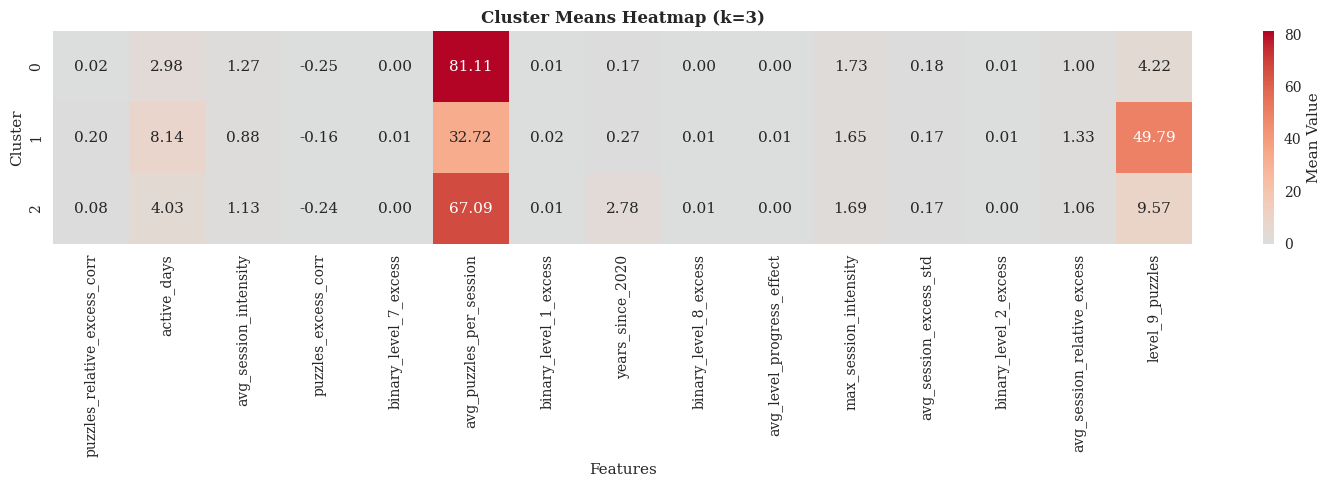

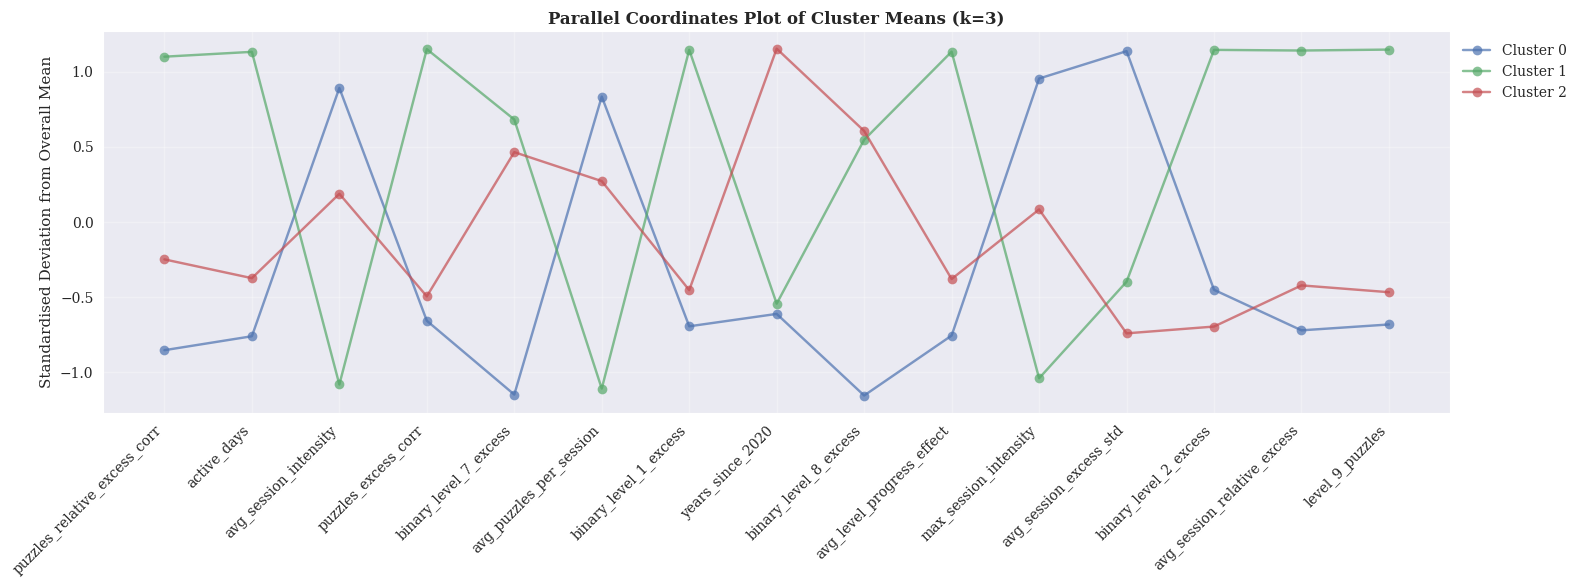

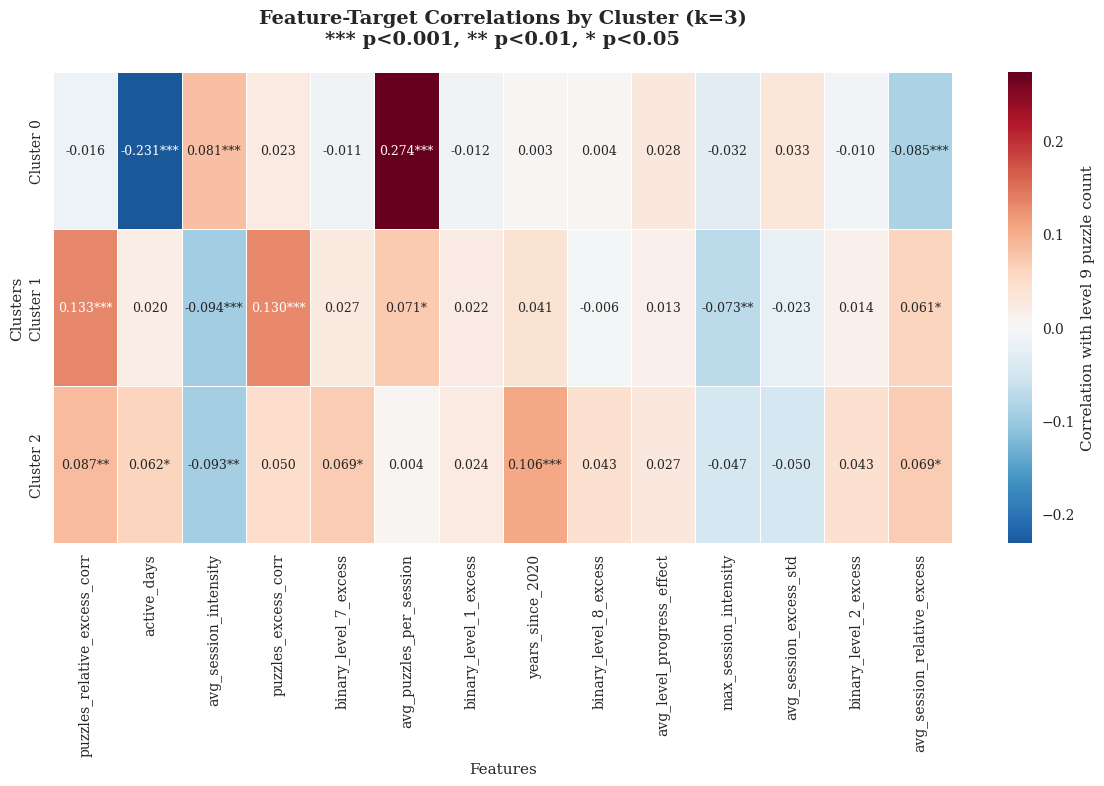

In [ ]:
analysis_df, kmeans, feature_summary, deviations, anova_df, corr_df = analyse_clusters(
        transformed_df=df,              
        original_df=org_df,     
        features=revised_kmeans_var,      
        k=3
    )